In [85]:
import numpy as np
import pandas as pd
import random
from sklearn.metrics import accuracy_score, log_loss
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc
import statistics
from sklearn.model_selection import StratifiedKFold, train_test_split
from scipy import interp

from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

print("We're using TF", tf.__version__)

We're using TF 1.13.1


In [86]:
data = pd.read_csv("train.csv")

In [87]:
X = data.drop("y", axis=1).values
y = data.y.values

feature_num = X.shape[1]

In [88]:
tf.reset_default_graph()
input_X = tf.placeholder(tf.float32, shape=(None, feature_num), name="input_X")
input_y = tf.placeholder(tf.float32, shape=(None, 1), name="input_y")

### Network construction
Adding new feature selection layer, via diagonal matrix with small weights

In [89]:
sess = tf.Session()

selection_weights = tf.Variable(tf.diag([random.random()/10000 for _ in range(feature_num)]), name="selection_weights")
layer_2_weights = tf.Variable(tf.random_normal(shape=[feature_num,93]), name="layer_2_weights")
layer_3_weights = tf.Variable(tf.random_normal(shape=[93,128]), name="layer_3_weights")
layer_4_weights = tf.Variable(tf.random_normal(shape=[128,64]), name="layer_4_weights")
out_layer_weights = tf.Variable(tf.random_normal(shape=[64,1]), name="out_layer_weights")

b2 = tf.Variable(tf.zeros([93]), name='Biases2')
b3 = tf.Variable(tf.zeros([128]), name='Biases3')
b4 = tf.Variable(tf.zeros([64]), name='Biases4')
b_out = tf.Variable(tf.zeros([1]), name='Biases_out')

layer_1 = tf.matmul(input_X, selection_weights)
layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, layer_2_weights), b2))
layer_3 = tf.nn.tanh(tf.add(tf.matmul(layer_2, layer_3_weights), b3))
layer_4 = tf.nn.tanh(tf.add(tf.matmul(layer_3, layer_4_weights), b4))
out_layer = tf.nn.softmax(tf.add(tf.matmul(layer_4, out_layer_weights), b_out))

### Custom loss function configuration


In [90]:
elastic_param1 = tf.constant(1.)
elastic_param2 = tf.constant(1.) 
elastic_main_loss = elastic_param1 * ((1-elastic_param2)/2 * 
                                      (tf.nn.l2_loss(layer_2_weights) 
                                       + tf.nn.l2_loss(layer_3_weights)
                                       + tf.nn.l2_loss(layer_4_weights)
                                       + tf.nn.l2_loss(out_layer_weights)) + 
                                        elastic_param2 * 
                                      (tf.reduce_sum(tf.math.abs(layer_2_weights))
                                      + tf.reduce_sum(tf.math.abs(layer_3_weights))
                                      + tf.reduce_sum(tf.math.abs(layer_4_weights))
                                      + tf.reduce_sum(tf.math.abs(out_layer_weights))))

elastic_param3 = tf.constant(1.)
elastic_param4 = tf.constant(1.)
elastic_selection_loss = elastic_param3 * ((1-elastic_param4)/2 * tf.nn.l2_loss(selection_weights) + 
                        elastic_param4 * tf.reduce_sum(tf.math.abs(selection_weights)))

# dtype issue
#loss = tf.losses.log_loss(labels=input_y, predictions=out_layer) + elastic_main_loss + elastic_selection_loss

loss = tf.losses.mean_squared_error(labels=input_y, predictions=out_layer) + elastic_main_loss + elastic_selection_loss

optimizer = tf.train.AdamOptimizer(0.0001)
train_step = optimizer.minimize(loss)

### Training
And visualising importance of features

Step #5000 L1w = [[-1.09854109e-05  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -5.62768491e-06  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.79146482e-05 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.08223385e-05
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -1.66086647e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00 -1.39573813e-05]]
Loss = 64148.203


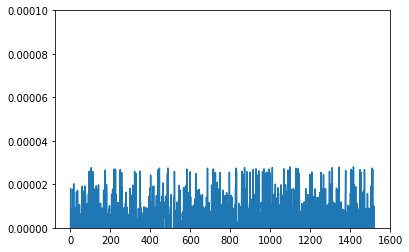

In [92]:
init = tf.global_variables_initializer()
writer = tf.summary.FileWriter('logs', sess.graph)
sess.run(init)
batch_size = 50

loss_vec = []
for i in range(5000):
    rand_index = np.random.choice(X.shape[0], size=batch_size)
    rand_x = X[rand_index]
    rand_y = np.transpose([y[rand_index]])
    sess.run(train_step, feed_dict={input_X: rand_x, input_y: rand_y})
    temp_loss = sess.run(loss, feed_dict={input_X: rand_x, input_y: rand_y})
    loss_vec.append(temp_loss) #temp_loss[0]
    if (i+1)%5000==0: #250
        sel_update = sess.run(selection_weights)
        print('Step #' + str(i+1) + ' L1w = ' + str(sel_update))
        print('Loss = ' + str(temp_loss))

    if (i+1)==5000: #1000
        sel_update = sess.run(selection_weights)
        plt.ylim(0, 0.0001)
        plt.plot(list(range(1524)), sel_update.diagonal())

dfs = selection_weights.eval(session=sess)
writer.close()

### Selecting columns with main features from the initial dataset

In [93]:
dfs_diag = dfs.diagonal()
dfs_mean = np.mean(dfs_diag)
X_new_dfs = []

feature_names = list(data.columns)
DFS_NAMES = []
for i in range(feature_num):
    if(dfs_diag[i] > dfs_mean):
        X_new_dfs.append(X[:, i])
        DFS_NAMES.append(feature_names[i])
X_new_dfs = np.array(X_new_dfs)
X_new_dfs = X_new_dfs.T
X_new_dfs.shape

(1105, 764)

### Random Forest

In [94]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100), 
                     threshold='1.25*median')
sel.fit(X, y)
X_new_forest = sel.transform(X)

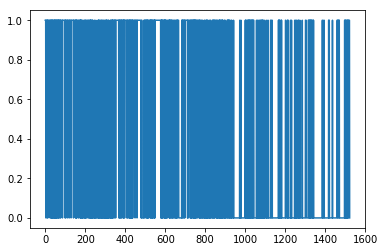

In [95]:
forest_output = list(map(lambda x: 1 if x else 0, sel.get_support()))
plt.plot(list(range(feature_num)), forest_output)

### Lasso feature seleciton

In [96]:
lsvc = LinearSVC(C=0.001, penalty="l1", dual=False, max_iter=2000).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new_lasso = model.transform(X)
X_new_lasso.shape

/home/dustedduke/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


(1105, 78)

### Models 
Training multiple models based on features extracted with DFS layer, Random Forest and Lasso 

Naive: 0.771756329113924   Forest: 0.7660205696202531   DFS: 0.7201344936708861
Naive: 0.798259493670886   Forest: 0.7274525316455697   DFS: 0.7810522151898734
Naive: 0.75   Forest: 0.712618670886076   DFS: 0.7521756329113924
Naive: 0.7796677215189873   Forest: 0.801621835443038   DFS: 0.7420886075949367
Naive: 0.7252768987341772   Forest: 0.6740506329113924   DFS: 0.728243670886076
Naive: 0.7958350347080441   Forest: 0.7868517762351981   DFS: 0.7986933442221313
Naive: 0.7417313189056758   Forest: 0.731523070641078   DFS: 0.7472437729685586
Naive: 0.7211106574111883   Forest: 0.7100857492854227   DFS: 0.76827276439363
Naive: 0.8389138423846467   Forest: 0.8223764801959983   DFS: 0.8113515720702327
Naive: 0.7707227439771336   Forest: 0.7043691302572478   DFS: 0.7811351572070233
Naive: 0.8368275316455697   Forest: 0.7365506329113924   DFS: 0.846123417721519
Naive: 0.853243670886076   Forest: 0.8362341772151899   DFS: 0.8348496835443039
Naive: 0.7658227848101267   Forest: 0.74545094936708

/home/dustedduke/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/dustedduke/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/dustedduke/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Naive: 0.834256329113924   Forest: 0.823378164556962   DFS: 0.8670886075949367


/home/dustedduke/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/dustedduke/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/dustedduke/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Naive: 0.7697784810126582   Forest: 0.9072389240506329   DFS: 0.640625


/home/dustedduke/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/dustedduke/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/dustedduke/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Naive: 0.8789556962025317   Forest: 0.8623417721518988   DFS: 0.8971518987341772


/home/dustedduke/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/dustedduke/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/dustedduke/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Naive: 0.7600870253164558   Forest: 0.7879746835443038   DFS: 0.817246835443038


/home/dustedduke/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/dustedduke/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/dustedduke/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/dustedduke/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimizati

Naive: 0.8609572784810127   Forest: 0.8477056962025317   DFS: 0.8668908227848101


/home/dustedduke/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/dustedduke/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/dustedduke/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/dustedduke/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimizati

Naive: 0.833401388321764   Forest: 0.8654552878726011   DFS: 0.8236014699877501


/home/dustedduke/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/dustedduke/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/dustedduke/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/dustedduke/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimizati

Naive: 0.7991016741527154   Forest: 0.8338097182523478   DFS: 0.8154348713760718


/home/dustedduke/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/dustedduke/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Naive: 0.8534095549203757   Forest: 0.86116782360147   DFS: 0.8215598203348305


/home/dustedduke/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/dustedduke/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Naive: 0.6431196406696611   Forest: 0.77766435279706   DFS: 0.7676602694977541


/home/dustedduke/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/dustedduke/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Naive: 0.6733360555328706   Forest: 0.8221723152307064   DFS: 0.8374846876276031
Naive: 0.9216772151898734   Forest: 0.913370253164557   DFS: 0.8856803797468354
Naive: 0.886867088607595   Forest: 0.8793512658227848   DFS: 0.9212816455696203
Naive: 0.9189082278481013   Forest: 0.8595727848101266   DFS: 0.8868670886075949
Naive: 0.9137658227848101   Forest: 0.9133702531645571   DFS: 0.9287974683544303
Naive: 0.9003164556962026   Forest: 0.9303797468354431   DFS: 0.9098101265822784
Naive: 0.9403838301347489   Forest: 0.9342588811759902   DFS: 0.9301755818701511
Naive: 0.8954675377705186   Forest: 0.9224173131890567   DFS: 0.934667211106574
Naive: 0.9097590853409555   Forest: 0.9138423846467947   DFS: 0.9179256839526336
Naive: 0.796243364638628   Forest: 0.837893017558187   DFS: 0.8468762760310331
Naive: 0.8738260514495713   Forest: 0.8436096365863618   DFS: 0.8770926908942425


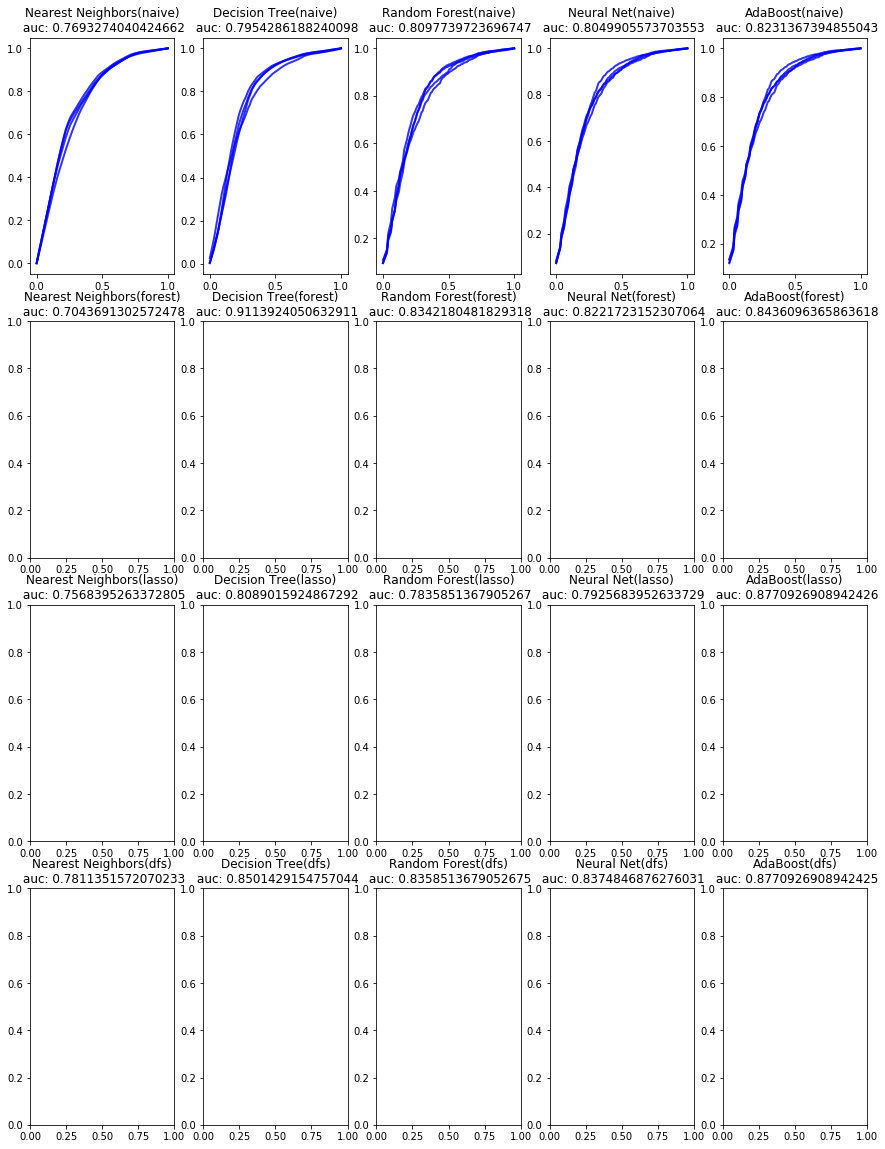

In [97]:
classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier()]

names = ["Nearest Neighbors", "Decision Tree", "Random Forest", 
         "Neural Net", "AdaBoost"]
 
folds = 10    

global_fpr = []
global_tpr = []
global_auc = []

global_fpr_forest = []
global_tpr_forest = []
global_auc_forest = []

global_fpr_lasso = []
global_tpr_lasso = []
global_auc_lasso = []

global_fpr_dfs = []
global_tpr_dfs = []
global_auc_dfs = []

mean_fpr = np.linspace(0, 1, 100)
mean_fpr_forest = np.linspace(0, 1, 100)
mean_fpr_lasso = np.linspace(0, 1, 100)
mean_fpr_dfs = np.linspace(0, 1, 100)

fig, axes = plt.subplots(nrows=4, ncols=len(classifiers), sharex=False, 
                         sharey=False, figsize=(15,20))

i = 0

skf = StratifiedKFold(n_splits=folds, shuffle=True)
for name, clf in zip(names, classifiers):
    for train_index, test_index in skf.split(X, y):
        
        # Naive
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf.fit(X_train, y_train)
        probs = clf.predict_proba(X_test)[:, 1]
        auc_naive = roc_auc_score(y_test, probs)
        fpr, tpr, thresholds = roc_curve(y_test, probs)
        
        global_auc.append(auc_naive)
        global_tpr.append(interp(mean_fpr, fpr, tpr))
        
        
        
        # Forest
        X_train_forest, X_test_forest = X_new_forest[train_index], X_new_forest[test_index]
        y_train_forest, y_test_forest = y[train_index], y[test_index]

        clf.fit(X_train_forest, y_train_forest)
        probs_forest = clf.predict_proba(X_test_forest)[:, 1]
        auc_forest = roc_auc_score(y_test_forest, probs_forest)
        fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_test_forest, probs_forest)
        
        global_auc_forest.append(auc_forest)
        global_tpr_forest.append(interp(mean_fpr_forest, fpr_forest, tpr_forest))

    
        # Lasso
        X_train_lasso, X_test_lasso = X_new_lasso[train_index], X_new_lasso[test_index]
        y_train_lasso, y_test_lasso = y[train_index], y[test_index]

        clf.fit(X_train_lasso, y_train_lasso)
        probs_lasso = clf.predict_proba(X_test_lasso)[:, 1]
        auc_lasso = roc_auc_score(y_test_lasso, probs_lasso)
        fpr_lasso, tpr_lasso, thresholds_lasso = roc_curve(y_test_lasso, probs_lasso)
        
        global_auc_lasso.append(auc_lasso)
        global_tpr_lasso.append(interp(mean_fpr_lasso, fpr_lasso, tpr_lasso))
    
    
    
        # DFS layer
        X_train_dfs, X_test_dfs = X_new_dfs[train_index], X_new_dfs[test_index]
        y_train_dfs, y_test_dfs = y[train_index], y[test_index]
        
        clf.fit(X_train_dfs, y_train_dfs)
        probs_dfs = clf.predict_proba(X_test_dfs)[:, 1]
        auc_dfs = roc_auc_score(y_test_dfs, probs_dfs)
        fpr_dfs, tpr_dfs, thresholds_dfs = roc_curve(y_test_dfs, probs_dfs)
        
        global_auc_dfs.append(auc_dfs)
        global_tpr_dfs.append(interp(mean_fpr_dfs, fpr_dfs, tpr_dfs))
        
        
        print("Naive: " + str(auc_naive) + "   Forest: " + str(auc_forest) + "   DFS: " + str(auc_dfs))

        
    # Visualization (ROC curves)
    mean_tpr = np.mean(global_tpr, axis=0) 
    mean_tpr_forest = np.mean(global_tpr_forest, axis=0)
    mean_tpr_lasso = np.mean(global_tpr_lasso, axis=0)
    mean_tpr_dfs = np.mean(global_tpr_dfs, axis=0)
    
    mean_tpr[-1] = 1.0
    mean_tpr_forest[-1] = 1.0
    mean_tpr_lasso[-1] = 1.0
    mean_tpr_dfs[-1] = 1.0
        
    auc_naive = statistics.mean(global_auc)

    axes[0, i].set_title(name + "(naive)\n " + "auc: " + auc_naive.astype(str))
    plt.ylim(0, 1)
    axes[0, i].plot(mean_fpr, mean_tpr, color='b',
         lw=2, alpha=.8)
    
    
    axes[1, i].set_title(name + "(forest)\n " + "auc: " + auc_forest.astype(str))
    plt.ylim(0, 1)
    axes[0, i].plot(mean_fpr_forest, mean_tpr_forest, color='b',
         lw=2, alpha=.8)
    
    
    axes[2, i].set_title(name + "(lasso)\n " + "auc: " + auc_lasso.astype(str))
    plt.ylim(0, 1)
    axes[0, i].plot(mean_fpr_lasso, mean_tpr_lasso, color='b',
         lw=2, alpha=.8)
    
    
    axes[3, i].set_title(name + "(dfs)\n " + "auc: " + auc_dfs.astype(str))
    plt.ylim(0, 1)
    axes[0, i].plot(mean_fpr_dfs, mean_tpr_dfs, color='b',
         lw=2, alpha=.8)
    
    
#     fpr_forest = [statistics.mean(k) for k in zip(*global_fpr_forest)]
#     tpr_forest = [statistics.mean(k) for k in zip(*global_tpr_forest)]
#     tpr[-1] = 1.0

#     auc_forest = statistics.mean(global_auc_forest)
    
#     axes[1, i].set_title(name + "(forest)\n " + "auc: " + auc_forest.astype(str))
#     plt.ylim(0, 1)
#     axes[1, i].plot(mean_fpr_forest, mean_tpr_forest, color='b',
#          lw=2, alpha=.8)

#     fpr_lasso = [statistics.mean(k) for k in zip(*global_fpr_lasso)]
#     tpr_forest = [statistics.mean(k) for k in zip(*global_tpr_lasso)]
#     tpr[-1] = 1.0

#     auc_forest = statistics.mean(global_auc_forest)
    
#     axes[2, i].set_title(name + "(forest)\n " + "auc: " + auc_forest.astype(str))
#     plt.ylim(0, 1)
#     axes[2, i].plot(mean_fpr_forest, mean_tpr_forest, color='b',
#          lw=2, alpha=.8)
    
#     fpr_dfs = [statistics.mean(k) for k in zip(*global_fpr_dfs)]
#     tpr_dfs = [statistics.mean(k) for k in zip(*global_tpr_dfs)]
#     auc_dfs = statistics.mean(global_auc_dfs)

#     axes[3, i].set_title(name + "(dfs)\n " + "auc: " + auc_dfs.astype(str))
#     plt.ylim(0, 1)
#     axes[3, i].plot(mean_fpr_dfs, mean_tpr_dfs, color='b',
#          lw=2, alpha=.8)
    
    i+=1
    
plt.show()

### NO FOLD TEST

(1105, 1524)
(1105, 658)
(1105, 756)
0.8771399431776791


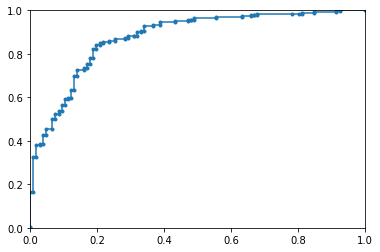

0.8904713338675604


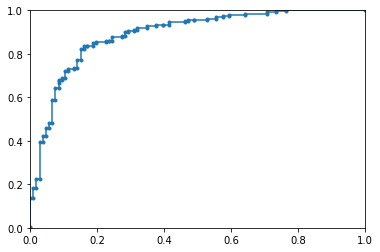

0.8713484373861732


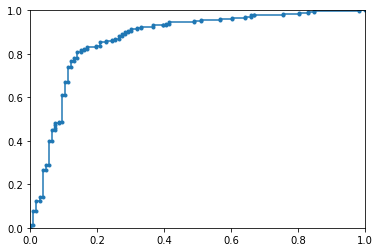

In [84]:
# no kfold test
print(X.shape)
print(X_new_forest.shape)
print(X_new_dfs.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = AdaBoostClassifier()
clf.fit(X_train, y_train)

probs = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot(fpr, tpr, marker='.')

print(auc)
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X_new_forest, y, test_size=0.33, random_state=42)
clf = AdaBoostClassifier()
clf.fit(X_train, y_train)

probs = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot(fpr, tpr, marker='.')

print(auc)
plt.show()


X_train, X_test, y_train, y_test = train_test_split(X_new_dfs, y, test_size=0.33, random_state=42)
clf = AdaBoostClassifier()
clf.fit(X_train, y_train)

probs = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot(fpr, tpr, marker='.')

print(auc)
plt.show()